In [ ]:
!pip install requests matplotlib

Delhi - Temp: 26.05°C, Feels Like: 26.05°C, Condition: Haze
Mumbai - Temp: 30.99°C, Feels Like: 37.57°C, Condition: Haze
Chennai - Temp: 29.99°C, Feels Like: 36.99°C, Condition: Mist
Bangalore - Temp: 22.68°C, Feels Like: 23.38°C, Condition: Rain
Kolkata - Temp: 25.97°C, Feels Like: 25.97°C, Condition: Haze
Hyderabad - Temp: 25.23°C, Feels Like: 25.51°C, Condition: Haze
Delhi - Temp: 26.05°C, Feels Like: 26.05°C, Condition: Haze
Mumbai - Temp: 30.99°C, Feels Like: 37.57°C, Condition: Haze
Chennai - Temp: 29.72°C, Feels Like: 36.72°C, Condition: Mist
Bangalore - Temp: 22.68°C, Feels Like: 23.38°C, Condition: Rain
Kolkata - Temp: 25.97°C, Feels Like: 25.97°C, Condition: Haze
Hyderabad - Temp: 25.23°C, Feels Like: 25.51°C, Condition: Haze
Delhi - Temp: 26.05°C, Feels Like: 26.05°C, Condition: Haze
Mumbai - Temp: 30.99°C, Feels Like: 37.57°C, Condition: Haze
Chennai - Temp: 29.72°C, Feels Like: 36.72°C, Condition: Mist
Bangalore - Temp: 22.68°C, Feels Like: 23.38°C, Condition: Rain
Kolkata

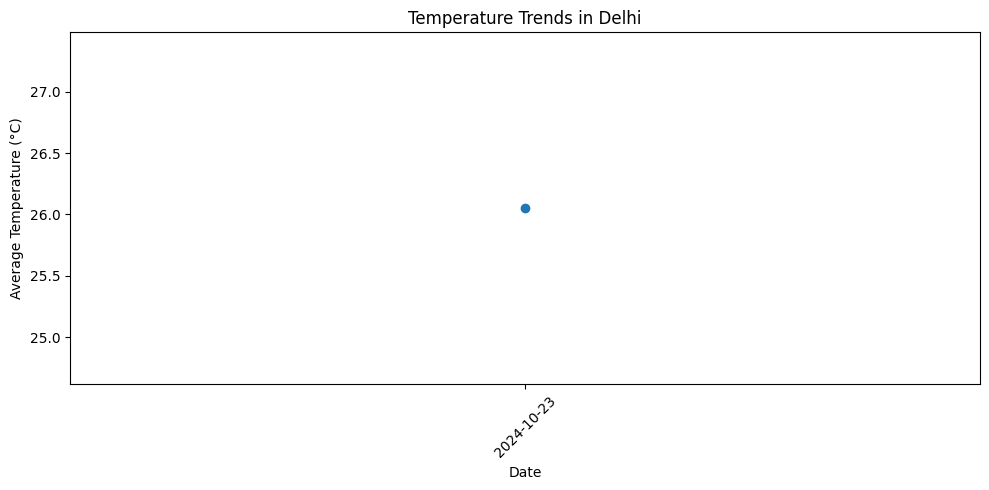

In [1]:
import requests
import sqlite3
from datetime import datetime
import matplotlib.pyplot as plt

# Your OpenWeatherMap API Key
API_KEY = '001f03e2073dfc11a4bba654b288c06f'

# List of Indian metro cities to monitor
cities = ['Delhi', 'Mumbai', 'Chennai', 'Bangalore', 'Kolkata', 'Hyderabad']

# Function to convert temperature from Kelvin to Celsius
def kelvin_to_celsius(kelvin):
    return kelvin - 273.15

# Function to get weather data for a specific city
def get_weather_data(city):
    url = f'http://api.openweathermap.org/data/2.5/weather?q={city}&appid={API_KEY}'
    response = requests.get(url)
    data = response.json()

    if response.status_code != 200 or 'main' not in data:
        print(f"Error fetching weather data for {city}: {data.get('message', 'Unknown error')}")
        return None
    return data

# Function to fetch weather data for all cities
def fetch_weather_data():
    weather_data = {}
    for city in cities:
        data = get_weather_data(city)
        if data is None:
            continue
        temp = kelvin_to_celsius(data['main']['temp'])
        feels_like = kelvin_to_celsius(data['main']['feels_like'])
        weather_condition = data['weather'][0]['main']
        timestamp = data['dt']

        weather_data[city] = {
            'temp': temp,
            'feels_like': feels_like,
            'condition': weather_condition,
            'time': datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')
        }
    return weather_data

# Function to store weather summary in SQLite database
def store_weather_summary(city, date, avg_temp, max_temp, min_temp, dominant_condition):
    conn = sqlite3.connect('weather_data.db')
    c = conn.cursor()
    c.execute('''CREATE TABLE IF NOT EXISTS weather_summary (
                    city TEXT,
                    date TEXT,
                    avg_temp REAL,
                    max_temp REAL,
                    min_temp REAL,
                    dominant_condition TEXT)''')

    c.execute('''INSERT INTO weather_summary (city, date, avg_temp, max_temp, min_temp, dominant_condition)
                 VALUES (?, ?, ?, ?, ?, ?)''',
              (city, date, avg_temp, max_temp, min_temp, dominant_condition))

    conn.commit()
    conn.close()

# Function to calculate daily weather summary
def calculate_daily_summary(weather_data, city):
    temps = [data['temp'] for data in weather_data]
    avg_temp = sum(temps) / len(temps)
    max_temp = max(temps)
    min_temp = min(temps)
    conditions = [data['condition'] for data in weather_data]
    dominant_condition = max(set(conditions), key=conditions.count)

    today = datetime.now().strftime('%Y-%m-%d')
    store_weather_summary(city, today, avg_temp, max_temp, min_temp, dominant_condition)

# Function to track and alert based on user-defined thresholds
def check_alert_thresholds(weather_data, alert_thresholds, alert_tracker):
    alerts = []
    for city, data in weather_data.items():
        temp = data['temp']
        if city in alert_tracker:
            last_temp = alert_tracker[city]
            # Trigger alert if threshold exceeded in two consecutive updates
            if temp > alert_thresholds['temp'] and last_temp > alert_thresholds['temp']:
                alerts.append(f"Alert! {city} temperature exceeded {alert_thresholds['temp']}°C: {temp:.2f}°C for two consecutive updates.")
        # Update last temperature
        alert_tracker[city] = temp
    return alerts

# Function to display temperature trends using matplotlib
def plot_temperature_trends(city):
    conn = sqlite3.connect('weather_data.db')
    c = conn.cursor()

    c.execute('''SELECT date, avg_temp FROM weather_summary WHERE city=?''', (city,))
    records = c.fetchall()

    if not records:
        print(f"No data available for {city} yet.")
        return

    dates = [record[0] for record in records]
    temps = [record[1] for record in records]

    plt.figure(figsize=(10, 5))
    plt.plot(dates, temps, marker='o')
    plt.title(f'Temperature Trends in {city}')
    plt.xlabel('Date')
    plt.ylabel('Average Temperature (°C)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    conn.close()

# Main function to fetch weather data and process it
def main():
    weather_updates = {}
    alert_tracker = {}
    alert_thresholds = {'temp': 35}  # Temperature alert threshold

    for _ in range(12):  # Simulate 12 updates
        weather_data = fetch_weather_data()

        if weather_data:
            # Print weather data
            for city, data in weather_data.items():
                print(f"{city} - Temp: {data['temp']:.2f}°C, Feels Like: {data['feels_like']:.2f}°C, Condition: {data['condition']}")

                # Store daily weather data for each city
                if city not in weather_updates:
                    weather_updates[city] = []
                weather_updates[city].append(data)

                # Calculate daily summary
                if len(weather_updates[city]) == 12:
                    calculate_daily_summary(weather_updates[city], city)

            # Check and display alerts
            alerts = check_alert_thresholds(weather_data, alert_thresholds, alert_tracker)
            for alert in alerts:
                print(alert)

    # Display temperature trends for one city (example: Delhi)
    plot_temperature_trends('Delhi')

# Run the main function
if __name__ == '__main__':
    main()


In [2]:
import requests


def kelvin_to_celsius(kelvin):
    return kelvin - 273.15


API_KEY = '001f03e2073dfc11a4bba654b288c06f'


def get_weather_data(city):
    url = f'http://api.openweathermap.org/data/2.5/weather?q={city}&appid={API_KEY}'
    response = requests.get(url)
    data = response.json()

    if response.status_code != 200 or 'main' not in data:
        print(f"Error fetching weather data for {city}: {data.get('message', 'Unknown error')}")
        return None
    return data

city = 'Delhi'
weather_data = get_weather_data(city)
print(weather_data)


{'coord': {'lon': 77.2167, 'lat': 28.6667}, 'weather': [{'id': 721, 'main': 'Haze', 'description': 'haze', 'icon': '50n'}], 'base': 'stations', 'main': {'temp': 299.2, 'feels_like': 299.2, 'temp_min': 299.2, 'temp_max': 299.2, 'pressure': 1011, 'humidity': 61, 'sea_level': 1011, 'grnd_level': 986}, 'visibility': 2500, 'wind': {'speed': 1.54, 'deg': 260}, 'clouds': {'all': 0}, 'dt': 1729696844, 'sys': {'type': 1, 'id': 9165, 'country': 'IN', 'sunrise': 1729645014, 'sunset': 1729685621}, 'timezone': 19800, 'id': 1273294, 'name': 'Delhi', 'cod': 200}


In [3]:
kelvin = weather_data['main']['temp']
celsius = kelvin_to_celsius(kelvin)
print(f"Temperature in Celsius: {celsius:.2f}°C")


Temperature in Celsius: 26.05°C


In [4]:
import json
import requests
from datetime import datetime

API_KEY = '001f03e2073dfc11a4bba654b288c06f'


cities = ['Delhi', 'Mumbai', 'Chennai', 'Bangalore', 'Kolkata', 'Hyderabad']


def kelvin_to_celsius(kelvin):
    return kelvin - 273.15

def get_weather_data(city):
    url = f'http://api.openweathermap.org/data/2.5/weather?q={city}&appid={API_KEY}'
    response = requests.get(url)
    data = response.json()

    if response.status_code != 200 or 'main' not in data:
        print(f"Error fetching weather data for {city}: {data.get('message', 'Unknown error')}")
        return None
    return data

def fetch_weather_data():
    weather_data = {}
    for city in cities:
        data = get_weather_data(city)
        if data is None:
            continue
        temp = kelvin_to_celsius(data['main']['temp'])
        feels_like = kelvin_to_celsius(data['main']['feels_like'])
        weather_condition = data['weather'][0]['main']
        timestamp = data['dt']

        weather_data[city] = {
            'temp': temp,
            'feels_like': feels_like,
            'condition': weather_condition,
            'time': datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')
        }
    return weather_data


all_weather_data = fetch_weather_data()


for city, data in all_weather_data.items():
    print(f"City: {city}")
    print(f"  Temperature: {data['temp']:.2f}°C")
    print(f"  Feels Like: {data['feels_like']:.2f}°C")
    print(f"  Condition: {data['condition']}")
    print(f"  Time: {data['time']}")
    print("-" * 40)


City: Delhi
  Temperature: 26.05°C
  Feels Like: 26.05°C
  Condition: Haze
  Time: 2024-10-23 15:20:44
----------------------------------------
City: Mumbai
  Temperature: 30.99°C
  Feels Like: 37.57°C
  Condition: Haze
  Time: 2024-10-23 15:20:44
----------------------------------------
City: Chennai
  Temperature: 29.72°C
  Feels Like: 36.72°C
  Condition: Mist
  Time: 2024-10-23 15:25:24
----------------------------------------
City: Bangalore
  Temperature: 22.68°C
  Feels Like: 23.38°C
  Condition: Rain
  Time: 2024-10-23 15:25:35
----------------------------------------
City: Kolkata
  Temperature: 25.97°C
  Feels Like: 25.97°C
  Condition: Haze
  Time: 2024-10-23 15:25:35
----------------------------------------
City: Hyderabad
  Temperature: 25.23°C
  Feels Like: 25.51°C
  Condition: Haze
  Time: 2024-10-23 15:20:45
----------------------------------------


In [5]:
import sqlite3

def store_weather_summary(city, date, avg_temp, max_temp, min_temp, dominant_condition):
    conn = sqlite3.connect('weather_data.db')  # Connect to SQLite database
    c = conn.cursor()

    c.execute('''CREATE TABLE IF NOT EXISTS weather_summary (
                    city TEXT,
                    date TEXT,
                    avg_temp REAL,
                    max_temp REAL,
                    min_temp REAL,
                    dominant_condition TEXT)''')

    c.execute('''INSERT INTO weather_summary (city, date, avg_temp, max_temp, min_temp, dominant_condition)
                 VALUES (?, ?, ?, ?, ?, ?)''', (city, date, avg_temp, max_temp, min_temp, dominant_condition))

    conn.commit()
    conn.close()

def calculate_daily_summary(weather_data, city):
    temps = [data['temp'] for data in weather_data]
    avg_temp = sum(temps) / len(temps)
    max_temp = max(temps)
    min_temp = min(temps)
    conditions = [data['condition'] for data in weather_data]
    dominant_condition = max(set(conditions), key=conditions.count)

    today = datetime.now().strftime('%Y-%m-%d')

    # Store the daily summary in the database
    store_weather_summary(city, today, avg_temp, max_temp, min_temp, dominant_condition)

example_weather_data = [
    {'temp': 30.5, 'condition': 'Clear'},
    {'temp': 32.0, 'condition': 'Clear'},
    {'temp': 33.1, 'condition': 'Clouds'},
    {'temp': 31.2, 'condition': 'Clear'}
]

calculate_daily_summary(example_weather_data, 'Delhi')


In [6]:
weather_updates = [
    {'temp': 35.2, 'condition': 'Clear'},
    {'temp': 36.7, 'condition': 'Clear'},
    {'temp': 35.9, 'condition': 'Clear'},

]
city = 'Delhi'
calculate_daily_summary(weather_updates, city)


In [7]:
import requests
from datetime import datetime

# Your OpenWeatherMap API Key
API_KEY = '001f03e2073dfc11a4bba654b288c06f'

# List of Indian metro cities to monitor
cities = ['Delhi', 'Mumbai', 'Chennai', 'Bangalore', 'Kolkata', 'Hyderabad']

# Function to convert temperature from Kelvin to Celsius
def kelvin_to_celsius(kelvin):
    return kelvin - 273.15

# Function to get weather data for a specific city
def get_weather_data(city):
    url = f'http://api.openweathermap.org/data/2.5/weather?q={city}&appid={API_KEY}'
    response = requests.get(url)
    data = response.json()

    if response.status_code != 200 or 'main' not in data:
        print(f"Error fetching weather data for {city}: {data.get('message', 'Unknown error')}")
        return None
    return data

# Function to fetch weather data for all cities
def fetch_weather_data():
    weather_data = {}
    for city in cities:
        data = get_weather_data(city)
        if data is None:
            continue
        temp = kelvin_to_celsius(data['main']['temp'])
        feels_like = kelvin_to_celsius(data['main']['feels_like'])
        weather_condition = data['weather'][0]['main']
        timestamp = data['dt']

        weather_data[city] = {
            'temp': temp,
            'feels_like': feels_like,
            'condition': weather_condition,
            'time': datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')
        }
    return weather_data

# Function to track and alert based on user-defined thresholds
def check_alert_thresholds(weather_data, alert_thresholds, alert_tracker):
    alerts = []
    for city, data in weather_data.items():
        temp = data['temp']
        if city in alert_tracker:
            last_temp = alert_tracker[city]
            # Trigger alert if threshold exceeded in two consecutive updates
            if temp > alert_thresholds['temp'] and last_temp > alert_thresholds['temp']:
                alerts.append(f"Alert! {city} temperature exceeded {alert_thresholds['temp']}°C: {temp:.2f}°C for two consecutive updates.")
        # Update last temperature
        alert_tracker[city] = temp
    return alerts

# Test the function with weather data
def main():
    alert_tracker = {}  # Keeps track of last temperatures for each city
    alert_thresholds = {'temp': 35}  # Temperature threshold for alerts

    # Fetch weather data
    weather_data = fetch_weather_data()

    # Check for temperature alerts
    alerts = check_alert_thresholds(weather_data, alert_thresholds, alert_tracker)

    # Print the weather data and alerts
    for city, data in weather_data.items():
        print(f"{city} - Temp: {data['temp']:.2f}°C, Feels Like: {data['feels_like']:.2f}°C, Condition: {data['condition']}")

    if alerts:
        for alert in alerts:
            print(alert)
    else:
        print("No alerts triggered.")

# Run the main function
if __name__ == '__main__':
    main()


Delhi - Temp: 26.05°C, Feels Like: 26.05°C, Condition: Haze
Mumbai - Temp: 30.99°C, Feels Like: 37.57°C, Condition: Haze
Chennai - Temp: 29.72°C, Feels Like: 36.72°C, Condition: Mist
Bangalore - Temp: 22.68°C, Feels Like: 23.38°C, Condition: Rain
Kolkata - Temp: 25.97°C, Feels Like: 25.97°C, Condition: Haze
Hyderabad - Temp: 25.23°C, Feels Like: 25.51°C, Condition: Haze
No alerts triggered.


Delhi - Temp: 26.05°C, Feels Like: 26.05°C, Condition: Haze
Mumbai - Temp: 30.99°C, Feels Like: 37.57°C, Condition: Haze
Chennai - Temp: 29.72°C, Feels Like: 36.72°C, Condition: Mist
Bangalore - Temp: 22.68°C, Feels Like: 23.38°C, Condition: Rain
Kolkata - Temp: 25.97°C, Feels Like: 25.97°C, Condition: Haze
Hyderabad - Temp: 25.23°C, Feels Like: 25.51°C, Condition: Haze


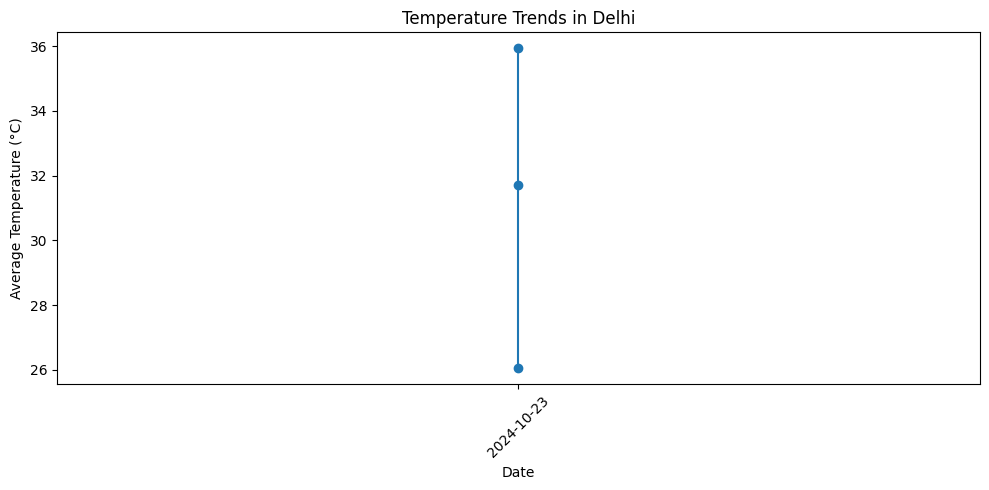

In [8]:
import requests
import sqlite3
from datetime import datetime
import matplotlib.pyplot as plt


API_KEY = '001f03e2073dfc11a4bba654b288c06f'


cities = ['Delhi', 'Mumbai', 'Chennai', 'Bangalore', 'Kolkata', 'Hyderabad']

def kelvin_to_celsius(kelvin):
    return kelvin - 273.15


def get_weather_data(city):
    url = f'http://api.openweathermap.org/data/2.5/weather?q={city}&appid={API_KEY}'
    response = requests.get(url)
    data = response.json()

    if response.status_code != 200 or 'main' not in data:
        print(f"Error fetching weather data for {city}: {data.get('message', 'Unknown error')}")
        return None
    return data


def fetch_weather_data():
    weather_data = {}
    for city in cities:
        data = get_weather_data(city)
        if data is None:
            continue
        temp = kelvin_to_celsius(data['main']['temp'])
        feels_like = kelvin_to_celsius(data['main']['feels_like'])
        weather_condition = data['weather'][0]['main']
        timestamp = data['dt']

        weather_data[city] = {
            'temp': temp,
            'feels_like': feels_like,
            'condition': weather_condition,
            'time': datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')
        }
    return weather_data


def plot_temperature_trends(city):
    conn = sqlite3.connect('weather_data.db')
    c = conn.cursor()

    c.execute('''SELECT date, avg_temp FROM weather_summary WHERE city=?''', (city,))
    records = c.fetchall()

    if not records:
        print(f"No data available for {city} yet.")
        return

    dates = [record[0] for record in records]
    temps = [record[1] for record in records]

    plt.figure(figsize=(10, 5))
    plt.plot(dates, temps, marker='o')
    plt.title(f'Temperature Trends in {city}')
    plt.xlabel('Date')
    plt.ylabel('Average Temperature (°C)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    conn.close()


def main():
    # Fetch and print weather data
    weather_data = fetch_weather_data()
    if weather_data:
        for city, data in weather_data.items():
            print(f"{city} - Temp: {data['temp']:.2f}°C, Feels Like: {data['feels_like']:.2f}°C, Condition: {data['condition']}")

    plot_temperature_trends('Delhi')

# Run the main function
if __name__ == '__main__':
    main()


Delhi - Temp: 26.05°C, Feels Like: 26.05°C, Humidity: 61%, Wind Speed: 1.54 m/s, Condition: Haze
Mumbai - Temp: 30.99°C, Feels Like: 37.57°C, Humidity: 70%, Wind Speed: 2.06 m/s, Condition: Haze
Chennai - Temp: 29.72°C, Feels Like: 36.72°C, Humidity: 81%, Wind Speed: 3.58 m/s, Condition: Mist
Bangalore - Temp: 22.68°C, Feels Like: 23.38°C, Humidity: 91%, Wind Speed: 1.03 m/s, Condition: Rain
Kolkata - Temp: 25.97°C, Feels Like: 25.97°C, Humidity: 89%, Wind Speed: 2.57 m/s, Condition: Haze
Hyderabad - Temp: 25.23°C, Feels Like: 25.51°C, Humidity: 65%, Wind Speed: 2.57 m/s, Condition: Haze
Delhi - Temp: 26.05°C, Feels Like: 26.05°C, Humidity: 61%, Wind Speed: 1.54 m/s, Condition: Haze
Mumbai - Temp: 30.99°C, Feels Like: 37.57°C, Humidity: 70%, Wind Speed: 2.06 m/s, Condition: Haze
Chennai - Temp: 29.72°C, Feels Like: 36.72°C, Humidity: 81%, Wind Speed: 3.58 m/s, Condition: Mist
Bangalore - Temp: 22.68°C, Feels Like: 23.38°C, Humidity: 91%, Wind Speed: 1.03 m/s, Condition: Rain
Kolkata - 

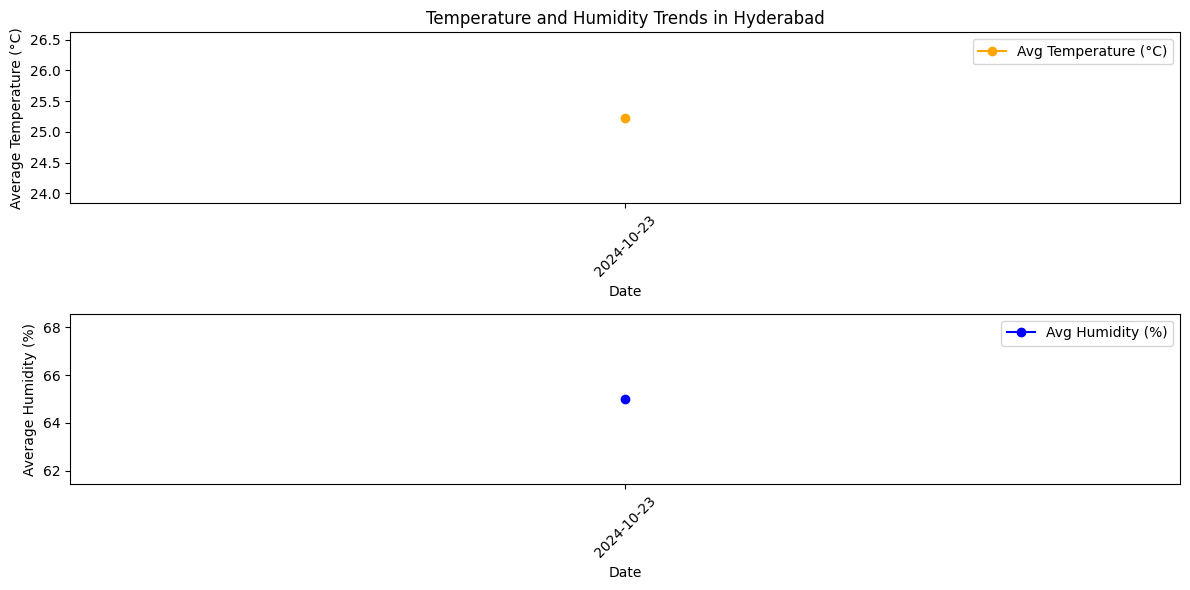

In [9]:
import requests
import sqlite3
from datetime import datetime
import matplotlib.pyplot as plt

# Your OpenWeatherMap API Key
API_KEY = '001f03e2073dfc11a4bba654b288c06f'

# List of Indian metro cities to monitor
cities = ['Delhi', 'Mumbai', 'Chennai', 'Bangalore', 'Kolkata', 'Hyderabad']

# Function to convert temperature from Kelvin to Celsius
def kelvin_to_celsius(kelvin):
    return kelvin - 273.15

# Function to get current weather data for a specific city
def get_current_weather_data(city):
    url = f'http://api.openweathermap.org/data/2.5/weather?q={city}&appid={API_KEY}'
    response = requests.get(url)
    data = response.json()

    if response.status_code != 200 or 'main' not in data:
        print(f"Error fetching weather data for {city}: {data.get('message', 'Unknown error')}")
        return None
    return data

# Function to fetch weather data for all cities
def fetch_weather_data():
    weather_data = {}
    for city in cities:
        current_data = get_current_weather_data(city)
        if current_data is None:
            continue

        # Extracting relevant data
        temp = kelvin_to_celsius(current_data['main']['temp'])
        feels_like = kelvin_to_celsius(current_data['main']['feels_like'])
        humidity = current_data['main']['humidity']
        wind_speed = current_data['wind']['speed']
        weather_condition = current_data['weather'][0]['main']
        timestamp = current_data['dt']

        weather_data[city] = {
            'temp': temp,
            'feels_like': feels_like,
            'humidity': humidity,
            'wind_speed': wind_speed,
            'condition': weather_condition,
            'time': datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')
        }
    return weather_data

# Function to store weather summary in SQLite database
def store_weather_summary(city, date, avg_temp, max_temp, min_temp, dominant_condition, avg_humidity, avg_wind_speed):
    conn = sqlite3.connect('weather_data.db')
    c = conn.cursor()

    # Drop the table if it exists (use cautiously)
    c.execute('DROP TABLE IF EXISTS weather_summary')

    c.execute('''CREATE TABLE IF NOT EXISTS weather_summary (
                    city TEXT,
                    date TEXT,
                    avg_temp REAL,
                    max_temp REAL,
                    min_temp REAL,
                    dominant_condition TEXT,
                    avg_humidity REAL,
                    avg_wind_speed REAL)''')

    c.execute('''INSERT INTO weather_summary (city, date, avg_temp, max_temp, min_temp, dominant_condition, avg_humidity, avg_wind_speed)
                 VALUES (?, ?, ?, ?, ?, ?, ?, ?)''',
              (city, date, avg_temp, max_temp, min_temp, dominant_condition, avg_humidity, avg_wind_speed))

    conn.commit()
    conn.close()

# Function to calculate daily weather summary
def calculate_daily_summary(weather_data, city):
    temps = [data['temp'] for data in weather_data]
    avg_temp = sum(temps) / len(temps)
    max_temp = max(temps)
    min_temp = min(temps)

    humidities = [data['humidity'] for data in weather_data]
    avg_humidity = sum(humidities) / len(humidities)

    wind_speeds = [data['wind_speed'] for data in weather_data]
    avg_wind_speed = sum(wind_speeds) / len(wind_speeds)

    conditions = [data['condition'] for data in weather_data]
    dominant_condition = max(set(conditions), key=conditions.count)

    today = datetime.now().strftime('%Y-%m-%d')
    store_weather_summary(city, today, avg_temp, max_temp, min_temp, dominant_condition, avg_humidity, avg_wind_speed)

# Function to plot temperature and humidity trends using matplotlib
def plot_weather_trends(city):
    conn = sqlite3.connect('weather_data.db')
    c = conn.cursor()

    # Fetching data from the weather_summary table
    c.execute('''SELECT date, avg_temp, avg_humidity FROM weather_summary WHERE city=?''', (city,))
    records = c.fetchall()

    if not records:
        print(f"No data available for {city} yet.")
        return

    # Extract dates, average temperatures, and humidity
    dates = [record[0] for record in records]
    avg_temps = [record[1] for record in records]
    avg_humidities = [record[2] for record in records]

    # Plotting temperature and humidity trends
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)  # Temperature plot
    plt.plot(dates, avg_temps, marker='o', label='Avg Temperature (°C)', color='orange')
    plt.title(f'Temperature and Humidity Trends in {city}')
    plt.xlabel('Date')
    plt.ylabel('Average Temperature (°C)')
    plt.xticks(rotation=45)
    plt.legend()

    plt.subplot(2, 1, 2)  # Humidity plot
    plt.plot(dates, avg_humidities, marker='o', label='Avg Humidity (%)', color='blue')
    plt.xlabel('Date')
    plt.ylabel('Average Humidity (%)')
    plt.xticks(rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()

    conn.close()

# Placeholder for alert checking function (to be implemented as needed)
def check_alert_thresholds(weather_data, alert_thresholds, alert_tracker):
    alerts = []
    for city, data in weather_data.items():
        if data['temp'] > alert_thresholds['temp']:
            alerts.append(f"Alert! {city} has exceeded the temperature threshold: {data['temp']}°C")
    return alerts

# Main function to fetch weather data and process it
def main():
    weather_updates = {}
    alert_tracker = {}
    alert_thresholds = {'temp': 35}  # Temperature alert threshold

    for _ in range(12):  # Simulate 12 updates
        weather_data = fetch_weather_data()

        if weather_data:
            # Print weather data
            for city, data in weather_data.items():
                print(f"{city} - Temp: {data['temp']:.2f}°C, Feels Like: {data['feels_like']:.2f}°C, Humidity: {data['humidity']}%, Wind Speed: {data['wind_speed']} m/s, Condition: {data['condition']}")

                # Store daily weather data for each city
                if city not in weather_updates:
                    weather_updates[city] = []
                weather_updates[city].append(data)

                # Calculate daily summary every 12 updates
                if len(weather_updates[city]) == 12:
                    calculate_daily_summary(weather_updates[city], city)

            # Check and display alerts
            alerts = check_alert_thresholds(weather_data, alert_thresholds, alert_tracker)
            for alert in alerts:
                print(alert)

    # Plot temperature and humidity trends for selected cities
    for city in cities:
        plot_weather_trends(city)

# Run the main function
if __name__ == '__main__':
    main()


In [ ]:
Github Link: